<a href="https://colab.research.google.com/github/shumshersubashgautam/AI_TRAINING/blob/master/Diabeticretinopathology.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
cd ..

/


In [2]:
cd root

/root


In [0]:
!mkdir .kaggle

In [4]:
cd .kaggle

/root/.kaggle


In [6]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"shumshersubash2018","key":"3577298afccc49ea94c2161d1e3696d4"}'}

In [7]:
cd ..

/root


In [8]:
cd ..

/


In [9]:
cd content

/content


In [0]:
!chmod 600 /root/.kaggle/kaggle.json

In [12]:
!kaggle competitions download -c aptos2019-blindness-detection

100% 8.00G/8.01G [02:54<00:00, 39.1MB/s]
100% 8.01G/8.01G [02:54<00:00, 49.4MB/s]
 99% 1.49G/1.50G [00:18<00:00, 93.6MB/s]
100% 1.50G/1.50G [00:18<00:00, 85.4MB/s]
  0% 0.00/53.7k [00:00<?, ?B/s]
100% 53.7k/53.7k [00:00<00:00, 46.7MB/s]
  0% 0.00/24.5k [00:00<?, ?B/s]
100% 24.5k/24.5k [00:00<00:00, 24.5MB/s]
  0% 0.00/28.3k [00:00<?, ?B/s]
100% 28.3k/28.3k [00:00<00:00, 26.7MB/s]


In [0]:
!unzip -q test_images -d test

In [0]:
!unzip -q train_images -d train

In [15]:
import pandas as pd
import numpy as np
import os

import cv2

from skimage.io import imread, imshow
from skimage.transform import resize

from PIL import Image

import tensorflow
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.metrics import categorical_accuracy, top_k_categorical_accuracy

from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
import itertools
import shutil
import matplotlib.pyplot as plt
%matplotlib inline

# Don't Show Warning Messages
import warnings
warnings.filterwarnings('ignore')

In [16]:
os.listdir('/content')

['.config',
 'train',
 'test',
 '.ipynb_checkpoints',
 'train.csv',
 'sample_submission.csv',
 'test.csv',
 'train_images.zip',
 'test_images.zip',
 'sample_data']

In [0]:
IMAGE_HEIGHT = 224
IMAGE_WIDTH = 224
IMAGE_CHANNELS = 3

In [18]:
df_train = pd.read_csv('/content/train.csv')


print(df_train.shape)

(3662, 2)


In [0]:
# Add a file_name column to df_train and df_test

def create_fname(x):
    
    fname = str(x) + '.png'
    
    return fname

df_train['file_name'] = df_train['id_code'].apply(create_fname)

In [20]:
df_train.head()

,id_code,diagnosis,file_name
0,000c1434d8d7,2,000c1434d8d7.png
1,001639a390f0,4,001639a390f0.png
2,0024cdab0c1e,1,0024cdab0c1e.png
3,002c21358ce6,0,002c21358ce6.png
4,005b95c28852,0,005b95c28852.png


In [21]:
# Check the target distribution
df_train['diagnosis'].value_counts()

0    1805
2     999
1     370
4     295
3     193
Name: diagnosis, dtype: int64

In [0]:
def binary_target(x):
    if x != 0:
        return 1
    else:
        return x
    
df_train['binary_target'] = df_train['diagnosis'].apply(binary_target)

In [23]:
df_train.head()

,id_code,diagnosis,file_name,binary_target
0,000c1434d8d7,2,000c1434d8d7.png,1
1,001639a390f0,4,001639a390f0.png,1
2,0024cdab0c1e,1,0024cdab0c1e.png,1
3,002c21358ce6,0,002c21358ce6.png,0
4,005b95c28852,0,005b95c28852.png,0


In [24]:
# Check the target distribution

df_train['binary_target'].value_counts()

1    1857
0    1805
Name: binary_target, dtype: int64

In [25]:
df_0 = df_train[df_train['binary_target'] == 0]
df_1 = df_train[df_train['binary_target'] == 1].sample(len(df_0), random_state=101)


df_data = pd.concat([df_0, df_1], axis=0).reset_index(drop=True)

df_data = shuffle(df_data)

print(df_data.shape)

df_data.head()

(3610, 4)


,id_code,diagnosis,file_name,binary_target
2698,abdb365cacbc,1,abdb365cacbc.png,1
618,5c817060c0ed,0,5c817060c0ed.png,0
3380,1dd9adcbfff4,2,1dd9adcbfff4.png,1
565,542964865b1e,0,542964865b1e.png,0
2107,9fefe2b44795,3,9fefe2b44795.png,1


In [26]:

# Check the new target distribution

df_data['binary_target'].value_counts()

1    1805
0    1805
Name: binary_target, dtype: int64

In [27]:
df_train, df_val = train_test_split(df_data, test_size=0.1, random_state=101)

print(df_train.shape)
print(df_val.shape)

(3249, 4)
(361, 4)


In [28]:
# check the train set target distribution
df_train['binary_target'].value_counts()

0    1634
1    1615
Name: binary_target, dtype: int64

In [29]:
# check the train set target distribution
df_val['binary_target'].value_counts()

1    190
0    171
Name: binary_target, dtype: int64

In [0]:
# Create a new directory
base_dir = 'base_dir'
os.mkdir(base_dir)


#[CREATE FOLDERS INSIDE THE BASE DIRECTORY]

# now we create sub folders inside 'base_dir':

# train_dir
    # a_0
    # b_1

# val_dir
    # a_0
    # b_1


# create a path to 'base_dir' to which we will join the names of the new folders
# train_dir
train_dir = os.path.join(base_dir, 'train_dir')
os.mkdir(train_dir)

# val_dir
val_dir = os.path.join(base_dir, 'val_dir')
os.mkdir(val_dir)


# [CREATE FOLDERS INSIDE THE TRAIN, VALIDATION AND TEST FOLDERS]
# Inside each folder we create seperate folders for each class

# create new folders inside train_dir
a_0 = os.path.join(train_dir, 'a_0')
os.mkdir(a_0)
b_1 = os.path.join(train_dir, 'b_1')
os.mkdir(b_1)


# create new folders inside val_dir
a_0 = os.path.join(val_dir, 'a_0')
os.mkdir(a_0)
b_1 = os.path.join(val_dir, 'b_1')
os.mkdir(b_1)

In [32]:

# Check that the folders exist
os.listdir('base_dir')

['val_dir', 'train_dir']

In [33]:
df_train.head()

,id_code,diagnosis,file_name,binary_target
988,91e82fe4e434,0,91e82fe4e434.png,0
955,8d4ff745a409,0,8d4ff745a409.png,0
859,7fdb177b8f7d,0,7fdb177b8f7d.png,0
2290,041f09eec1e8,2,041f09eec1e8.png,1
2426,7350c50667c5,2,7350c50667c5.png,1


In [0]:
# Set the file_name as the index in df_data
df_data.set_index('file_name', inplace=True)

In [0]:
# Get a list of train and val images
train_list = list(df_train['file_name'])

# ============================
# Transfer the train images
# ============================

for fname in train_list:
    
    label = df_data.loc[fname,'binary_target']
    
    if label == 0:
        sub_folder = 'a_0'
        # source path to image
        src = os.path.join('/content/train', fname)
        # destination path to image
        dst = os.path.join(train_dir, sub_folder, fname)
        
        image = cv2.imread(src)
        image = cv2.resize(image, (IMAGE_HEIGHT, IMAGE_WIDTH))
        cv2.imwrite(dst, image)
        # save the image at the destination
        # save the image using PIL
        #result = Image.fromarray(image.astype(np.uint8))
        #result.save(dst)
        # copy the image from the source to the destination
        #shutil.copyfile(src, dst)
        
        
    if label == 1:
        sub_folder = 'b_1'
        # source path to image
        src = os.path.join('/content/train', fname)
        # destination path to image
        dst = os.path.join(train_dir, sub_folder, fname)
        
        image = cv2.imread(src)
        image = cv2.resize(image, (IMAGE_HEIGHT, IMAGE_WIDTH))
        cv2.imwrite(dst, image)

In [0]:
# ============================
# Transfer the val images
# ============================

# Get a list of train and val images
val_list = list(df_val['file_name'])

for fname in val_list:
    
    label = df_data.loc[fname,'binary_target']
    
    if label == 0:
        sub_folder = 'a_0'
        # source path to image
        src = os.path.join('/content/train', fname)
        # destination path to image
        dst = os.path.join(val_dir, sub_folder, fname)
        
        image = cv2.imread(src)
        image = cv2.resize(image, (IMAGE_HEIGHT, IMAGE_WIDTH))
        cv2.imwrite(dst, image)
        
        
    if label == 1:
        sub_folder = 'b_1'
        # source path to image
        src = os.path.join('/content/train', fname)
        # destination path to image
        dst = os.path.join(val_dir, sub_folder, fname)
        
        image = cv2.imread(src)
        image = cv2.resize(image, (IMAGE_HEIGHT, IMAGE_WIDTH))
        cv2.imwrite(dst, image)

In [39]:
# Check how many images are in the train sub folders

print(len(os.listdir('base_dir/train_dir/a_0')))
print(len(os.listdir('base_dir/train_dir/b_1')))

1634
1615


In [40]:
# Check how many images are in the val sub folders

print(len(os.listdir('base_dir/val_dir/a_0')))
print(len(os.listdir('base_dir/val_dir/b_1')))

171
190


In [0]:
train_path = 'base_dir/train_dir'
val_path = 'base_dir/val_dir'

num_train_samples = len(df_train)
num_val_samples = len(df_val)
train_batch_size = 5
val_batch_size = 5

# Get the number of train and val steps
train_steps = np.ceil(num_train_samples / train_batch_size)
val_steps = np.ceil(num_val_samples / val_batch_size)

In [42]:
# Pre-process the input images in the same way as the ImageNet images 
# were pre-processed when they were used to train MobileNet.
datagen = ImageDataGenerator(
    preprocessing_function= \
    tensorflow.keras.applications.mobilenet.preprocess_input)

train_gen = datagen.flow_from_directory(train_path,
                                            target_size=(IMAGE_HEIGHT,IMAGE_WIDTH),
                                            batch_size=train_batch_size)

val_gen = datagen.flow_from_directory(val_path,
                                            target_size=(IMAGE_HEIGHT,IMAGE_WIDTH),
                                            batch_size=val_batch_size)

# Note: shuffle=False causes the test dataset to not be shuffled
# We are only going to use this to make a prediction on the val set. That's
# why the path is set as val_path
test_gen = datagen.flow_from_directory(val_path,
                                            target_size=(IMAGE_HEIGHT,IMAGE_WIDTH),
                                            batch_size=1,
                                            shuffle=False)

Found 3249 images belonging to 2 classes.
Found 361 images belonging to 2 classes.
Found 361 images belonging to 2 classes.


In [43]:
# create a copy of a mobilenet model

mobile = tensorflow.keras.applications.mobilenet.MobileNet()

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
17227776/17225924 [==============================] - 2s 0us/step


In [44]:
mobile.summary()

Model: "mobilenet_1.00_224"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, 225, 225, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 112, 112, 32

In [45]:
# The layers are set up as a list.

type(mobile.layers)

list

In [46]:
# How many layers does MobileNet have?
len(mobile.layers)

93

In [0]:
# CREATE THE MODEL ARCHITECTURE

# Exclude the last 5 layers of the above model.
# This will include all layers up to and including global_average_pooling2d_1
x = mobile.layers[-6].output

# Create a new dense layer for predictions
# 2 corresponds to the number of classes
x = Dropout(0.25)(x)
predictions = Dense(2, activation='softmax')(x)

# inputs=mobile.input selects the input layer, outputs=predictions refers to the
# dense layer we created above.

model = Model(inputs=mobile.input, outputs=predictions)

In [48]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, 225, 225, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 112, 112, 32)      128   

In [0]:
# We need to choose how many layers we actually want to be trained.

# Here we are freezing the weights of all layers except the
# last 23 layers in the new model.
# The last 23 layers of the model will be trained.

for layer in model.layers[:-23]:
    layer.trainable = False

In [50]:
# Get the labels that are associated with each index
print(val_gen.class_indices)

{'a_0': 0, 'b_1': 1}


In [0]:
# Add weights to try to make the model more sensitive to some classes.
# The dictionary is ordered as per the above output.

# Here the weights are set to 1 so this is not affecting the model.
# These weights can be changed later, if needed.

class_weights={
    0: 1.0, # Class 0
    1: 1.0, # Class 1
}

In [52]:
model.compile(Adam(lr=0.01), loss='categorical_crossentropy', 
              metrics=[categorical_accuracy])


filepath = "model.h5"
checkpoint = ModelCheckpoint(filepath, monitor='val_categorical_accuracy', verbose=1, 
                             save_best_only=True, mode='max')


reduce_lr = ReduceLROnPlateau(monitor='val_categorical_accuracy', factor=0.5, patience=2, 
                                   verbose=1, mode='max', min_lr=0.00001)
                              
                              
callbacks_list = [checkpoint, reduce_lr]

history = model.fit_generator(train_gen, steps_per_epoch=train_steps, 
                              class_weight=class_weights,
                    validation_data=val_gen,
                    validation_steps=val_steps,
                    epochs=10, verbose=1,
                   callbacks=callbacks_list)

Epoch 1/10
 73/650 [==>...........................] - ETA: 17s - loss: 0.2590 - categorical_accuracy: 0.9418
Epoch 00001: val_categorical_accuracy improved from -inf to 0.94183, saving model to model.h5
650/650 [==============================] - 30s 46ms/step - loss: 0.4331 - categorical_accuracy: 0.8941 - val_loss: 0.2590 - val_categorical_accuracy: 0.9418
Epoch 2/10
 70/650 [==>...........................] - ETA: 18s - loss: 0.1823 - categorical_accuracy: 0.9457
Epoch 00002: val_categorical_accuracy improved from 0.94183 to 0.94737, saving model to model.h5
650/650 [==============================] - 23s 36ms/step - loss: 0.1763 - categorical_accuracy: 0.9452 - val_loss: 0.1767 - val_categorical_accuracy: 0.9474
Epoch 3/10
 70/650 [==>...........................] - ETA: 17s - loss: 0.1613 - categorical_accuracy: 0.9486
Epoch 00003: val_categorical_accuracy improved from 0.94737 to 0.95014, saving model to model.h5
650/650 [==============================] - 23s 35ms/step - loss: 0.1385

In [53]:

# Here the best epoch will be used.

model.load_weights('model.h5')

val_loss, val_categorical_accuracy = \
model.evaluate_generator(test_gen, 
                        steps=len(df_val))

print('val_loss:', val_loss)
print('val_categorical_accuracy:', val_categorical_accuracy)

val_loss: 0.1375817962449944
val_categorical_accuracy: 0.9529086


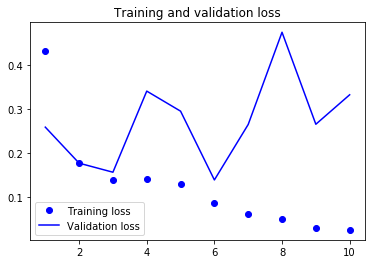

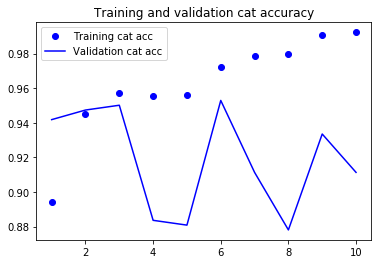

<Figure size 432x288 with 0 Axes>

In [54]:
# display the loss and accuracy curves

import matplotlib.pyplot as plt

acc = history.history['categorical_accuracy']
val_acc = history.history['val_categorical_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.figure()

plt.plot(epochs, acc, 'bo', label='Training cat acc')
plt.plot(epochs, val_acc, 'b', label='Validation cat acc')
plt.title('Training and validation cat accuracy')
plt.legend()
plt.figure()



plt.show()

In [55]:
# Get the labels of the test images.

test_labels = test_gen.classes

# We need these to plot the confusion matrix.
test_labels

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

In [56]:
# Print the label associated with each class
test_gen.class_indices

{'a_0': 0, 'b_1': 1}

In [57]:
# make a prediction on the val data
predictions = model.predict_generator(test_gen, steps=len(df_val), verbose=1)

361/361 [==============================] - 4s 11ms/step


In [58]:
predictions.shape

(361, 2)

In [0]:
# Source: Scikit Learn website
# http://scikit-learn.org/stable/auto_examples/
# model_selection/plot_confusion_matrix.html#sphx-glr-auto-examples-model-
# selection-plot-confusion-matrix-py


def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

In [60]:
test_labels.shape

(361,)

In [0]:

# argmax returns the index of the max value in a row
cm = confusion_matrix(test_labels, predictions.argmax(axis=1))

In [62]:

test_gen.class_indices

{'a_0': 0, 'b_1': 1}

Confusion matrix, without normalization
[[165   6]
 [ 11 179]]


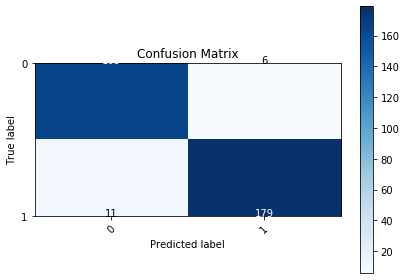

In [63]:
# Define the labels of the class indices. These need to match the 
# order shown above.
cm_plot_labels = ['0', '1']

plot_confusion_matrix(cm, cm_plot_labels, title='Confusion Matrix')

In [0]:
# Get the index of the class with the highest probability score
y_pred = np.argmax(predictions, axis=1)

# Get the labels of the test images.
y_true = test_gen.classes

In [65]:
from sklearn.metrics import classification_report

# Generate a classification report
report = classification_report(y_true, y_pred, target_names=cm_plot_labels)

print(report)

              precision    recall  f1-score   support

           0       0.94      0.96      0.95       171
           1       0.97      0.94      0.95       190

    accuracy                           0.95       361
   macro avg       0.95      0.95      0.95       361
weighted avg       0.95      0.95      0.95       361

